# GDSCv2 Analysis - Erlotinib (10 clusters)

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
from pyBasket.common import load_obj, save_obj
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc
from pyBasket.clustering import get_cluster_df_by_basket, plot_PCA, get_patient_df
from pyBasket.preprocessing import select_rf, check_rf

# Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

# Do PCA and colour by basket (tissues)

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535586 0.40877607 0.42098227]


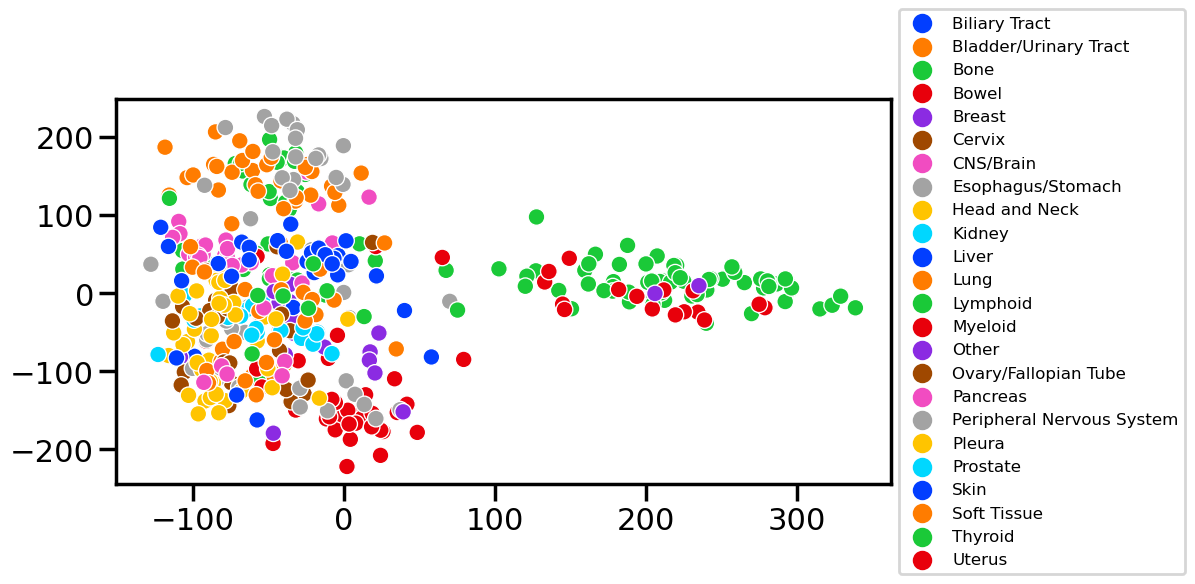

In [10]:
_ = plot_PCA(expr_df, n_components=10, hue=tissues)

# Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

## Collect the samples and responses for the drug

In [13]:
drug_name = 'Erlotinib'

In [14]:
samples = tissue_df.index.values
response_dict = response_df[drug_name].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [15]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
441,Thyroid,ASH-3,0.082204
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.078680
444,Thyroid,IHH-4,0.020141


## Drop all the NaN responses

In [16]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
440,Thyroid,WRO,0.018343
441,Thyroid,ASH-3,0.082204
443,Thyroid,HTC-C3,0.078680
444,Thyroid,IHH-4,0.020141


In [17]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [18]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,28,28
Breast,10,10
CNS/Brain,14,14
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [19]:
df['responses'].max(), df['responses'].min()

(0.352487709036072, 0.0)

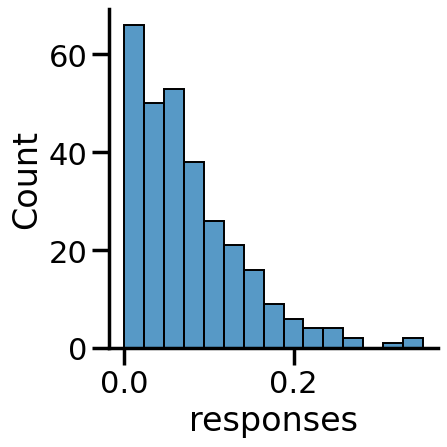

In [20]:
sns.displot(df['responses'])

In [21]:
df['responses'].mean(), df['responses'].median()

(0.07533823628570624, 0.06098308922444)

# Select baskets for analysis

Select some baskets

In [22]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

Use all baskets

In [23]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [24]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
293,Thyroid,WRO,0.018343
294,Thyroid,ASH-3,0.082204
295,Thyroid,HTC-C3,0.078680
296,Thyroid,IHH-4,0.020141


In [25]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((298, 19957), (446, 19957))

In [26]:
expr_df_filtered

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,3.205753,-9.965784,7.307272,-0.607968,0.481533,-9.965784,0.725387,5.847553,4.118905,4.821918,...,-6.475129,-6.749269,-9.965784,-9.965784,2.933364,-9.965784,-2.224737,-1.366209,-1.616199,-9.965784
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


In [27]:
drug_response = df_filtered.set_index('samples').drop(columns=['tissues'])
drug_response

,responses
samples,
TGBC24TKB,0.128392
EGI-1,0.057719
TGBC1TKB,0.051036
ETK-1,0.096227
SW1710,0.071891
...,...
WRO,0.018343
ASH-3,0.082204
HTC-C3,0.078680


## Feature selection using random forest

In [28]:
try: # try to load previously selected features
    fname = os.path.join('results', '%s_expr_df_selected.p' % drug_name)
    expr_df_selected = load_obj(fname)
    
except FileNotFoundError: # if not found, then re-run feature selection
    expr_df_selected = select_rf(expr_df_filtered, drug_response, n_splits=5, percentile_threshold=90, top_genes=500)
    save_obj(expr_df_selected, fname)

In [29]:
importance_df = check_rf(expr_df_selected, drug_response, test_size=0.2)

Test set results using selected features:
MSE: 0.0032920842730129398
R^2: 0.20947838405718378


In [30]:
expr_df_selected

,ENSG00000090621.14,ENSG00000132517.15,ENSG00000146648.18,ENSG00000149043.16,ENSG00000152894.14,ENSG00000163347.6,ENSG00000168143.9,ENSG00000180638.17,ENSG00000198888.2,ENSG00000205420.11,...,ENSG00000116752.6,ENSG00000116791.14,ENSG00000116906.13,ENSG00000117280.13,ENSG00000117385.16,ENSG00000117560.8,ENSG00000118096.8,ENSG00000118292.9,ENSG00000118705.17,ENSG00000118785.14
TGBC24TKB,6.381521,-1.739429,3.321716,-0.004531,4.734547,5.931521,3.111430,1.966194,13.627491,2.205512,...,5.162435,5.147299,5.606865,2.998651,2.689027,-4.084599,1.582791,-2.710111,7.812905,5.147392
EGI-1,7.610135,-0.751374,5.163625,1.493216,4.720908,6.417578,3.203289,-1.841590,13.199545,-1.218443,...,4.925232,5.226792,5.603523,2.670388,3.690611,-3.501878,3.994157,2.254687,7.025284,-4.545513
TGBC1TKB,6.751622,-1.513449,5.945249,0.627148,5.272171,4.621619,2.635736,-1.039889,12.951333,7.054224,...,6.148827,5.062208,5.476686,3.565310,2.989053,-3.608304,2.541695,-0.928687,7.818634,4.432519
ETK-1,7.070839,0.127958,5.787218,-0.107128,6.046211,5.308687,2.477480,-1.037587,12.310494,0.961998,...,5.247601,4.840509,6.286441,3.783611,4.020878,-4.522908,3.410838,0.532800,8.133642,9.654010
SW1710,7.775491,-2.199953,5.858155,-2.758373,5.425618,4.544722,-4.269562,-0.381611,12.271514,-6.245291,...,5.025107,7.285653,5.875248,4.852093,6.105435,-4.621762,3.015028,0.782099,7.713363,9.941758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,7.837784,-1.353844,3.763408,-6.732831,5.742105,4.760012,-2.607410,-2.643596,10.482648,-5.459191,...,5.281934,5.111793,4.432248,2.312542,5.967269,-4.153537,2.695865,0.825085,6.924745,4.096984
ASH-3,7.723500,-2.473594,5.331743,-6.200127,4.661784,1.397889,-3.950847,-3.144996,12.233519,-5.668614,...,5.997219,5.313866,4.264601,3.448109,6.406388,-4.216887,4.299667,1.986339,7.446398,1.274876
HTC-C3,6.924446,-0.875604,5.030717,-4.996494,6.072599,9.227226,0.302072,-2.257324,12.757065,-3.826678,...,5.712599,5.132686,5.115367,4.164872,4.130017,-4.510880,5.400644,0.639323,7.529029,1.770304
IHH-4,6.970922,-1.798209,5.552850,-5.065087,3.918782,3.639364,-3.606497,-2.172558,13.085928,-9.965784,...,4.845341,4.250295,5.615404,4.699264,4.436642,-4.521843,3.689322,1.936225,6.832362,0.901152


## Do PCA again on these samples

Before feature selection (using all 19957 transcripts)

PCA explained variance [0.13829637 0.22985784 0.29027512 0.32311007 0.34617996 0.36607902
 0.38141863 0.39592658 0.40932345 0.42133835]


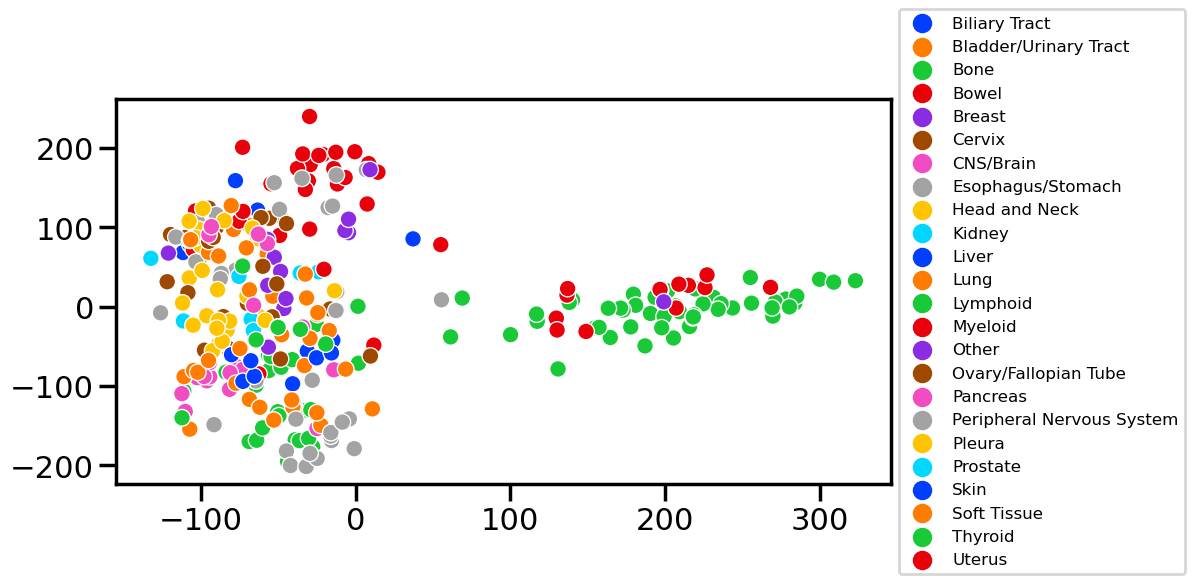

In [31]:
pc1, pc2 = plot_PCA(expr_df_filtered, n_components=10, hue=df_filtered['tissues'].values)

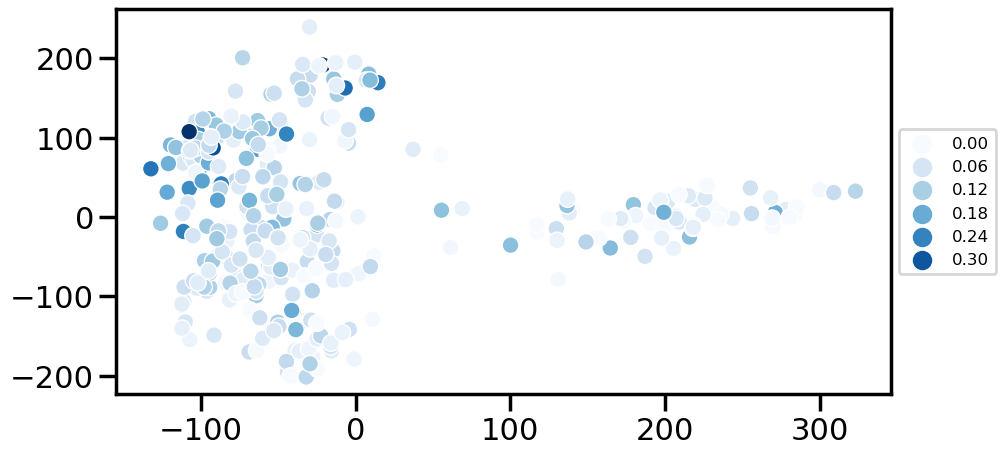

In [32]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

After feature selection (using 500 transcripts)

PCA explained variance [0.2443426  0.31842748 0.37138039 0.41483141 0.43467953 0.45420608
 0.47068115 0.48621428 0.5008843  0.51525205]


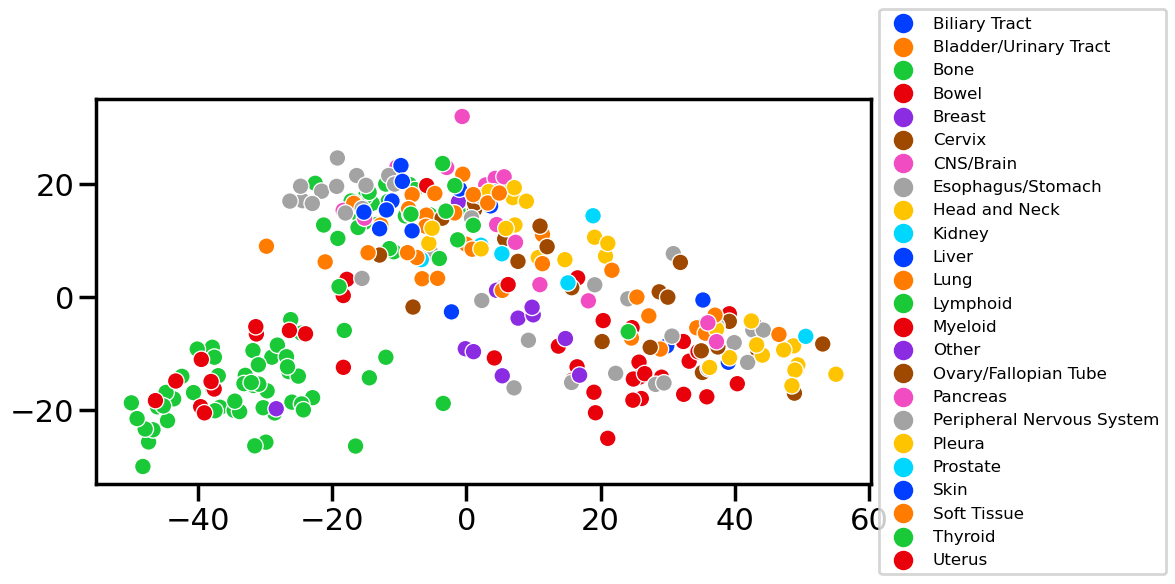

In [33]:
pc1, pc2 = plot_PCA(expr_df_selected, n_components=10, hue=df_filtered['tissues'].values)

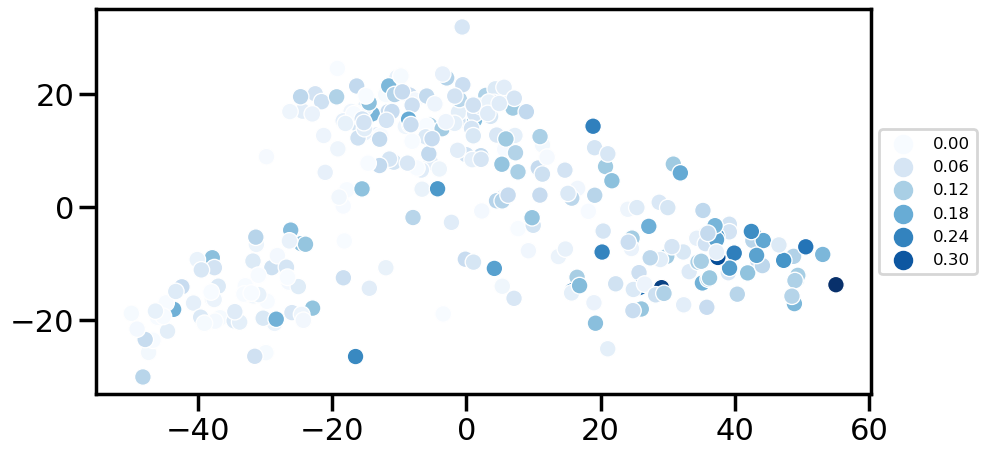

In [34]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

# Try clustering

In [35]:
expr_df_selected.shape

(298, 500)

In [36]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
TGBC24TKB,Biliary Tract,0.128392
EGI-1,Biliary Tract,0.057719
TGBC1TKB,Biliary Tract,0.051036
ETK-1,Biliary Tract,0.096227
SW1710,Bladder/Urinary Tract,0.071891
...,...,...
WRO,Thyroid,0.018343
ASH-3,Thyroid,0.082204
HTC-C3,Thyroid,0.078680


In [37]:
C = 10

In [38]:
kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_selected)

cluster_labels = kmeans.labels_
cluster_labels

array([4, 4, 0, 4, 2, 0, 2, 0, 0, 1, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 1,
       1, 6, 1, 2, 6, 1, 6, 6, 2, 6, 6, 2, 4, 7, 4, 7, 4, 4, 4, 4, 0, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 2, 9, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7,
       7, 7, 7, 7, 0, 7, 4, 0, 0, 0, 9, 0, 2, 7, 0, 0, 7, 1, 0, 2, 1, 2,
       6, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 4, 4, 0, 0, 7, 4, 4, 0, 4, 4,
       4, 0, 0, 4, 0, 1, 4, 4, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 5, 0, 5, 4, 9, 4, 9, 9, 9, 1, 9, 4,
       0, 9, 4, 1, 9, 9, 9, 7, 5, 9, 9, 8, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8,
       8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 3, 3, 8, 3, 8, 8,
       3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 3, 3, 1, 8, 3, 3, 3, 3, 8, 3,
       8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 2, 4, 3, 4, 4, 2, 2, 4, 2, 1, 4, 2,
       0, 7, 2, 4, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 7, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2], dtype=i

PCA explained variance [0.2443426  0.31842748 0.37138039 0.41483141 0.43467953 0.45420608
 0.47068115 0.48621428 0.5008843  0.51525205]


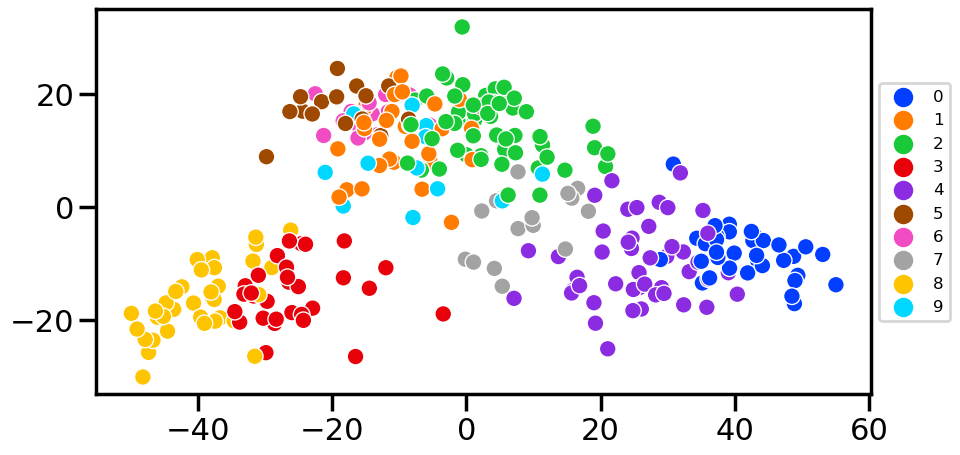

In [39]:
_ = plot_PCA(expr_df_selected, n_components=10, hue=cluster_labels)

# Run basket trial analysis

In [40]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [41]:
K = len(basket_names)
K, C

(24, 10)

Create clustering dataframe

In [42]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(298, 298)

In [43]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels, normalise=False)
cluster_df

,sk_0,sk_1,sk_2,sk_3,sk_4,sk_5,sk_6,sk_7,sk_8,sk_9
Biliary Tract,1,0,0,0,3,0,0,0,0,0
Bladder/Urinary Tract,3,0,2,0,0,0,0,0,0,0
Bone,0,5,5,0,0,0,15,0,0,0
Bowel,1,1,1,0,22,0,0,2,0,1
Breast,1,0,0,0,0,0,0,9,0,0
CNS/Brain,0,2,11,0,0,0,1,0,0,0
Cervix,7,1,1,0,1,0,0,2,0,1
Esophagus/Stomach,6,2,0,0,10,0,0,1,0,0
Head and Neck,12,1,3,0,0,0,0,0,0,0
Kidney,0,0,5,0,0,0,0,0,0,0


<AxesSubplot: >

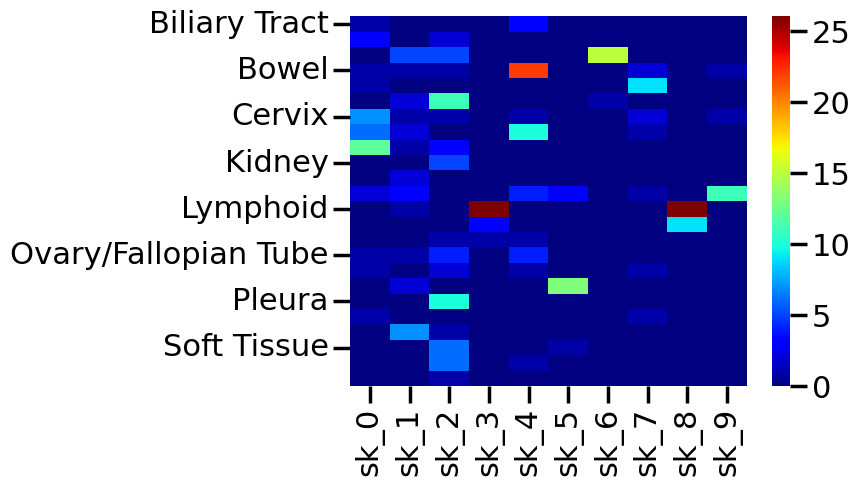

In [44]:
sns.heatmap(cluster_df, cmap='jet')

## Prepare patient data

In [45]:
patient_df = get_patient_df(df_filtered, cluster_labels)

In [46]:
patient_df

,tissues,responses,basket_number,cluster_number,responsive
samples,,,,,
TGBC24TKB,Biliary Tract,0.128392,0,4,0
EGI-1,Biliary Tract,0.057719,0,4,1
TGBC1TKB,Biliary Tract,0.051036,0,0,1
ETK-1,Biliary Tract,0.096227,0,4,0
SW1710,Bladder/Urinary Tract,0.071891,1,2,0
...,...,...,...,...,...
WRO,Thyroid,0.018343,22,2,1
ASH-3,Thyroid,0.082204,22,2,0
HTC-C3,Thyroid,0.078680,22,4,0


## Define models

No. of samples to collect before and after burn-in during MCMC.

In [47]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [48]:
model_s = get_patient_model_simple(patient_df)

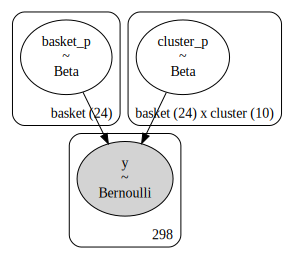

In [49]:
pm.model_to_graphviz(model_s)

In [50]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 49 seconds.


In [51]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[Biliary Tract],0.67,0.22,0.28,1.00,0.0,0.0,32790.0,12287.0,1.0
basket_p[Bladder/Urinary Tract],0.71,0.19,0.38,1.00,0.0,0.0,27871.0,11847.0,1.0
basket_p[Bone],0.74,0.14,0.51,1.00,0.0,0.0,21307.0,13113.0,1.0
basket_p[Bowel],0.69,0.18,0.41,1.00,0.0,0.0,19117.0,13002.0,1.0
basket_p[Breast],0.62,0.20,0.29,0.99,0.0,0.0,25212.0,13610.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[Uterus, 7]",0.50,0.29,0.02,0.96,0.0,0.0,44817.0,11552.0,1.0
"cluster_p[Uterus, 9]",0.50,0.28,0.04,0.97,0.0,0.0,45143.0,11949.0,1.0
"cluster_p[Uterus, 5]",0.50,0.29,0.06,1.00,0.0,0.0,38124.0,11865.0,1.0
"cluster_p[Uterus, 8]",0.50,0.29,0.05,0.99,0.0,0.0,42981.0,11135.0,1.0


In [52]:
# az.plot_ess(
#     trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

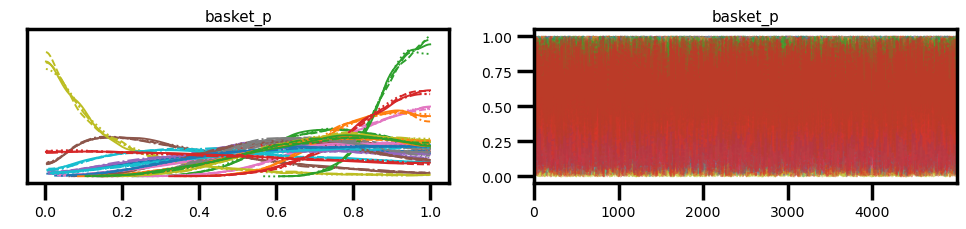

In [53]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

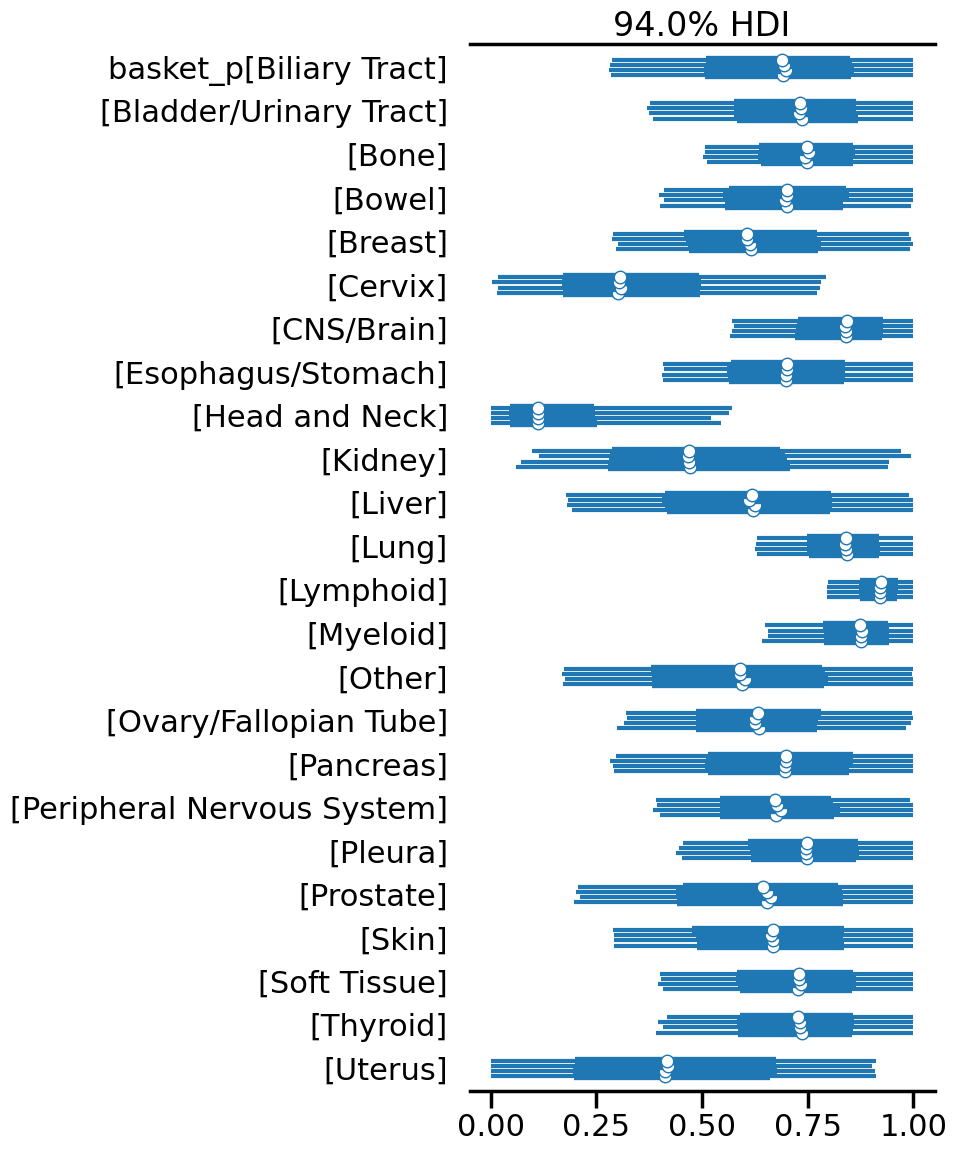

In [54]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [55]:
stacked_s = az.extract(trace_s)

In [56]:
inferred_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
inferred_basket_s.shape

(24,)

In [57]:
inferred_cluster_s = np.mean(stacked_s.cluster_p.values, axis=2)
inferred_cluster_s.shape

(24, 10)

In [58]:
inferred_basket_s_tiled = np.tile(inferred_basket_s, (C, 1)).T
inferred_mat_s = inferred_basket_s_tiled * inferred_cluster_s
inferred_mat_s.shape

(24, 10)

### Hierarchical model 1

This hierarchical model suffers from a lot of divergences. See:
- https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7
- https://stats.stackexchange.com/questions/67443/does-the-beta-distribution-have-a-conjugate-prior

In [59]:
model_h1 = get_patient_model_hierarchical(patient_df)

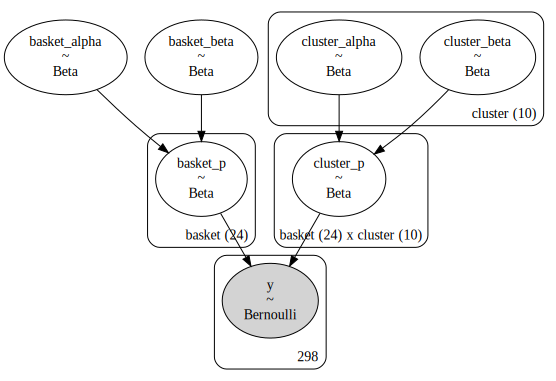

In [60]:
pm.model_to_graphviz(model_h1)

In [61]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_alpha, basket_beta, cluster_alpha, cluster_beta, basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 209 seconds.
There were 1300 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1496 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1672 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1754 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5122, but should be close to 0.8. Try to increase the number of tuning steps.


In [62]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_alpha,0.84,0.13,0.60,1.00,0.00,0.00,5535.0,5471.0,1.00
basket_beta,0.47,0.22,0.09,0.85,0.01,0.01,622.0,790.0,1.01
cluster_alpha[4],0.45,0.23,0.08,0.89,0.01,0.00,1239.0,1399.0,1.00
cluster_alpha[0],0.72,0.20,0.36,1.00,0.00,0.00,4054.0,3937.0,1.00
cluster_alpha[2],0.76,0.18,0.44,1.00,0.00,0.00,4772.0,5815.0,1.00
...,...,...,...,...,...,...,...,...,...
"cluster_p[Uterus, 7]",0.55,0.36,0.01,1.00,0.00,0.00,3355.0,1601.0,1.00
"cluster_p[Uterus, 9]",0.58,0.36,0.01,1.00,0.00,0.00,2859.0,2136.0,1.00
"cluster_p[Uterus, 5]",0.60,0.35,0.03,1.00,0.00,0.00,2543.0,1446.0,1.00
"cluster_p[Uterus, 8]",0.59,0.36,0.01,1.00,0.00,0.00,3078.0,2151.0,1.00


In [63]:
# az.plot_ess(
#     trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

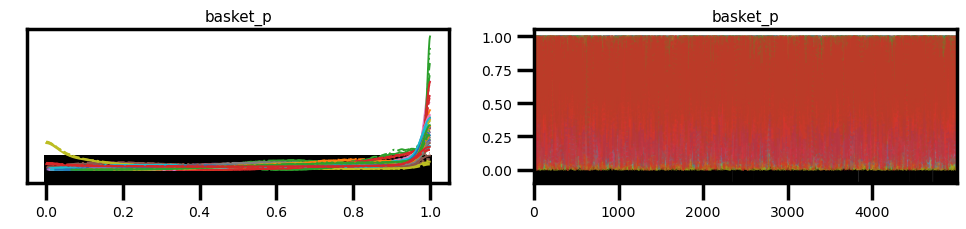

In [64]:
az.plot_trace(trace_h1, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

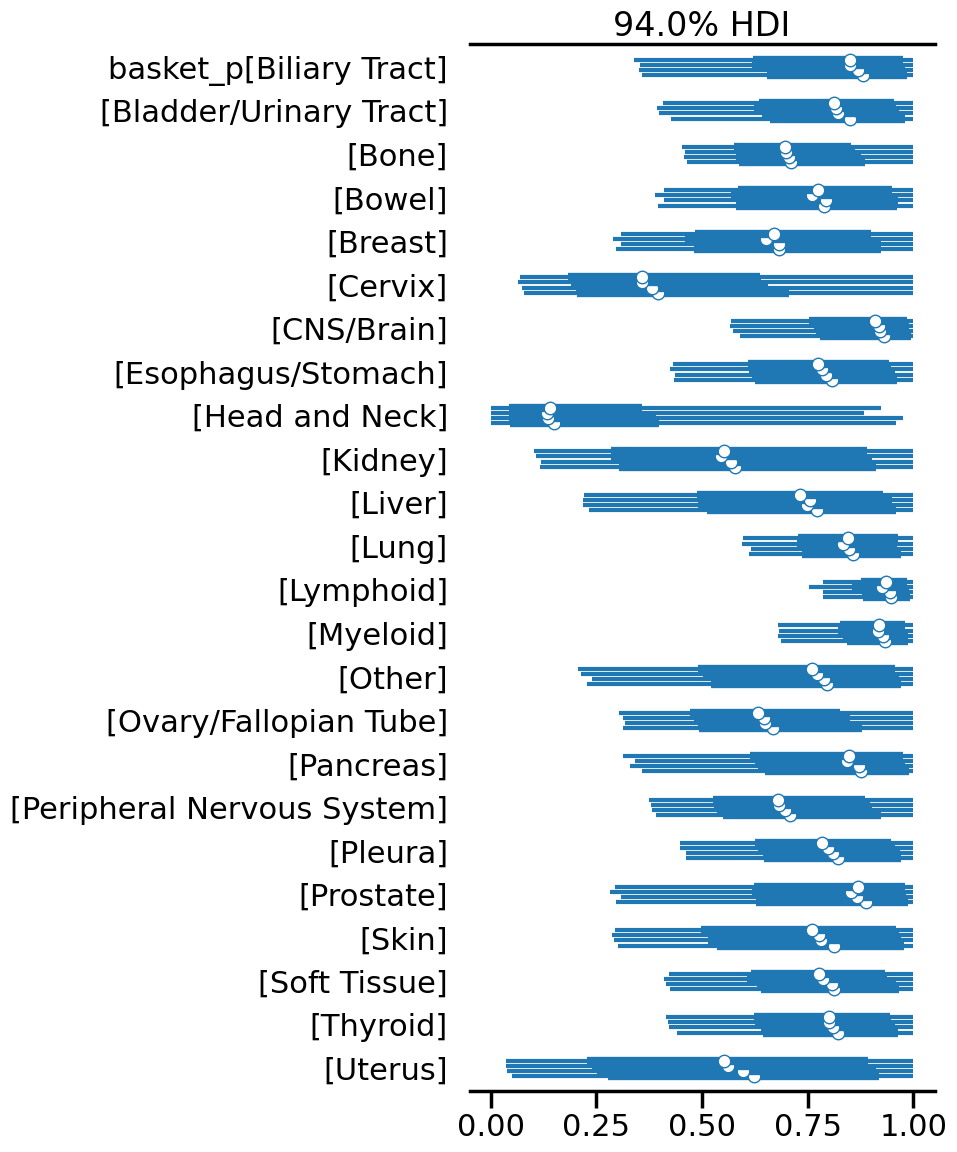

In [65]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [66]:
stacked_h1 = az.extract(trace_h1)

In [67]:
inferred_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
inferred_basket_h1.shape

(24,)

In [68]:
inferred_cluster_h1 = np.mean(stacked_h1.cluster_p.values, axis=2)
inferred_cluster_h1.shape

(24, 10)

In [69]:
inferred_basket_h1_tiled = np.tile(inferred_basket_h1, (C, 1)).T
inferred_mat_h1 = inferred_basket_h1_tiled * inferred_cluster_h1
inferred_mat_h1.shape

(24, 10)

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [70]:
model_h2 = get_patient_model_hierarchical_log_odds(patient_df)

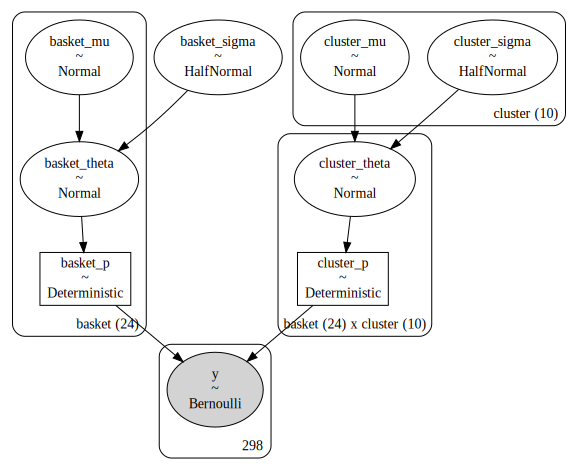

In [71]:
pm.model_to_graphviz(model_h2)

In [72]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [73]:
model_h2_nc = get_patient_model_hierarchical_log_odds_nc(patient_df)

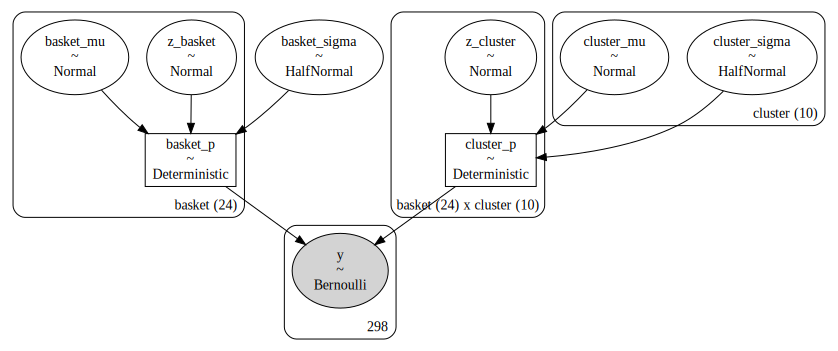

In [74]:
pm.model_to_graphviz(model_h2_nc)

In [75]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 99 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [76]:
az.summary(trace_h2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[Biliary Tract],0.15,0.98,-1.76,1.94,0.01,0.01,23985.0,13680.0,1.0
z_basket[Bladder/Urinary Tract],0.20,0.98,-1.59,2.03,0.01,0.01,22542.0,13826.0,1.0
z_basket[Bone],0.14,0.97,-1.72,1.96,0.01,0.01,19818.0,13720.0,1.0
z_basket[Bowel],0.13,0.95,-1.65,1.93,0.01,0.01,21521.0,14403.0,1.0
z_basket[Breast],0.07,0.96,-1.77,1.82,0.01,0.01,24276.0,15608.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[Uterus, 7]",0.71,0.23,0.27,1.00,0.00,0.00,17225.0,14215.0,1.0
"cluster_p[Uterus, 9]",0.69,0.23,0.27,1.00,0.00,0.00,18896.0,14346.0,1.0
"cluster_p[Uterus, 5]",0.73,0.21,0.34,1.00,0.00,0.00,18751.0,16026.0,1.0
"cluster_p[Uterus, 8]",0.76,0.19,0.40,1.00,0.00,0.00,15260.0,12472.0,1.0


In [77]:
# az.plot_ess(
#     trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

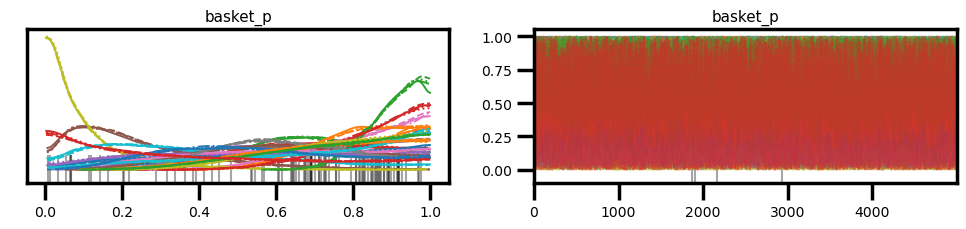

In [78]:
az.plot_trace(trace_h2, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

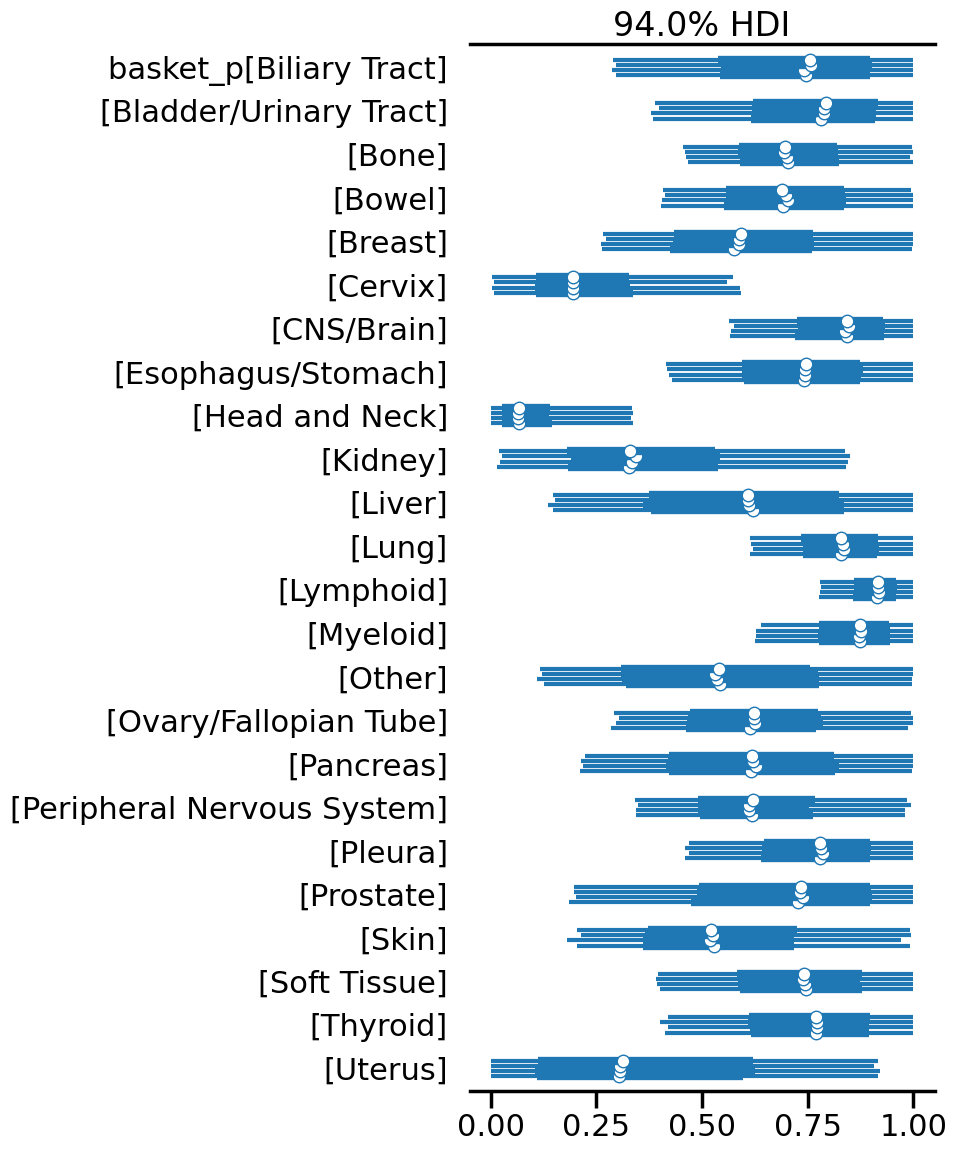

In [79]:
az.plot_forest(trace_h2, var_names=['basket_p'])

In [80]:
stacked_h2 = az.extract(trace_h2)

In [81]:
inferred_basket_h2 = np.mean(stacked_h2.basket_p.values, axis=1)
inferred_basket_h2.shape

(24,)

In [82]:
inferred_cluster_h2 = np.mean(stacked_h2.cluster_p.values, axis=2)
inferred_cluster_h2.shape

(24, 10)

In [83]:
inferred_basket_h2_tiled = np.tile(inferred_basket_h2, (C, 1)).T
inferred_mat_h2 = inferred_basket_h2_tiled * inferred_cluster_h2
inferred_mat_h2.shape

(24, 10)

## Compare the matrices

In [84]:
predicted_basket_s_df = pd.DataFrame({'prob': inferred_basket_s, 'basket': range(len(inferred_basket_s))})
predicted_basket_h1_df = pd.DataFrame({'prob': inferred_basket_h1, 'basket': range(len(inferred_basket_h1))})
predicted_basket_h2_df = pd.DataFrame({'prob': inferred_basket_h2, 'basket': range(len(inferred_basket_h2))})

Text(0.5, 1.0, 'Inferred (hierarchical log-odds)')

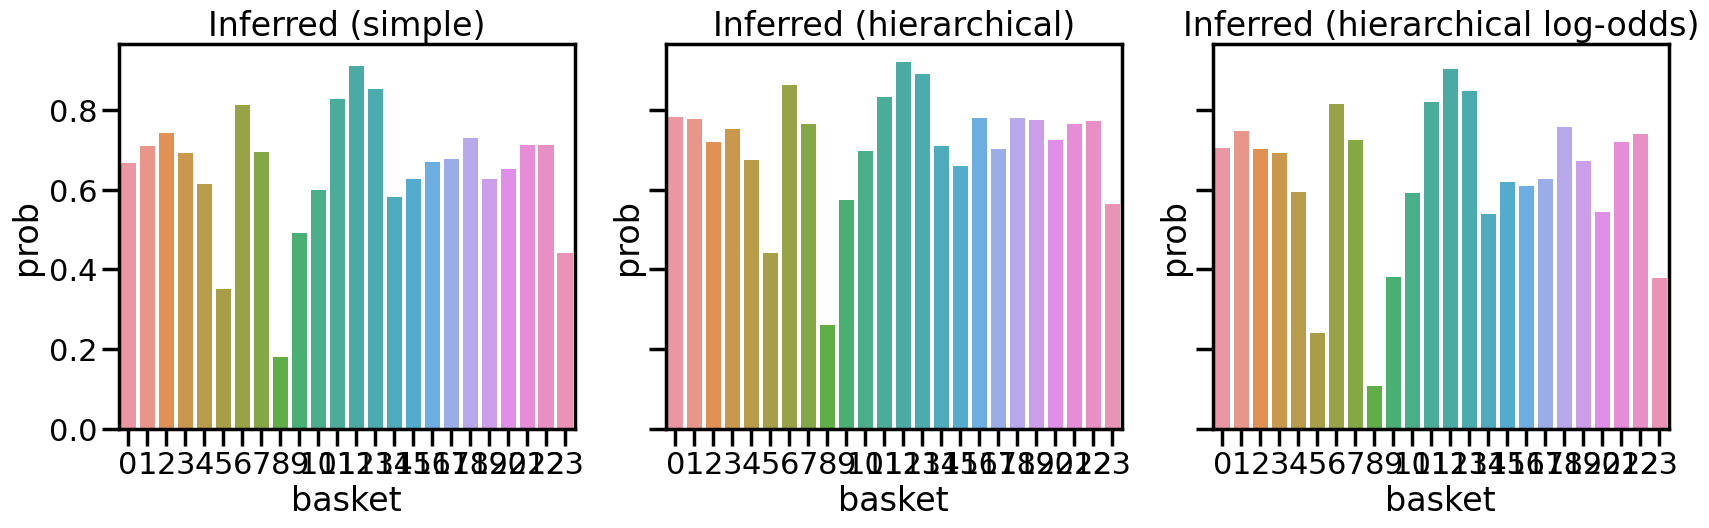

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('Inferred (simple)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Inferred (hierarchical)')

sns.barplot(data=predicted_basket_h2_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('Inferred (hierarchical log-odds)')

Text(1321.8954248366013, 0.5, 'Baskets')

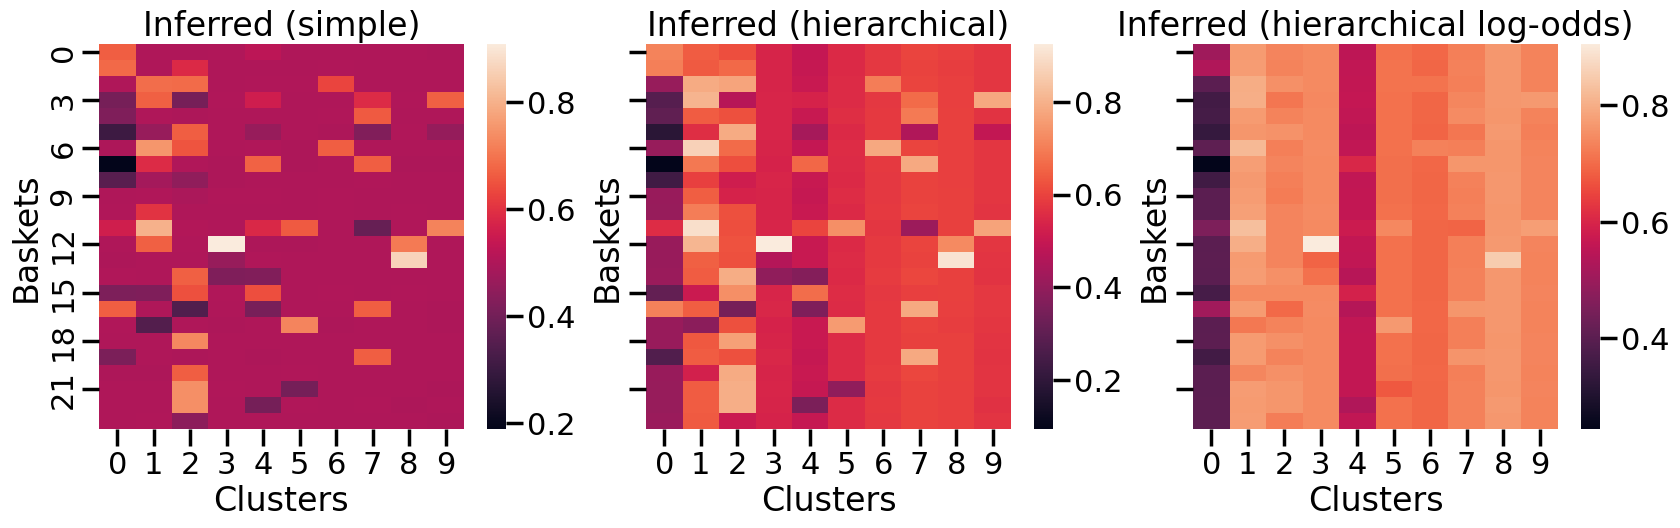

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
    
sns.heatmap(inferred_cluster_s, ax=ax[0])
ax[0].set_title('Inferred (simple)')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_cluster_h1, ax=ax[1])
ax[1].set_title('Inferred (hierarchical)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_cluster_h2, ax=ax[2])
ax[2].set_title('Inferred (hierarchical log-odds)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')

Text(1321.8954248366013, 0.5, 'Baskets')

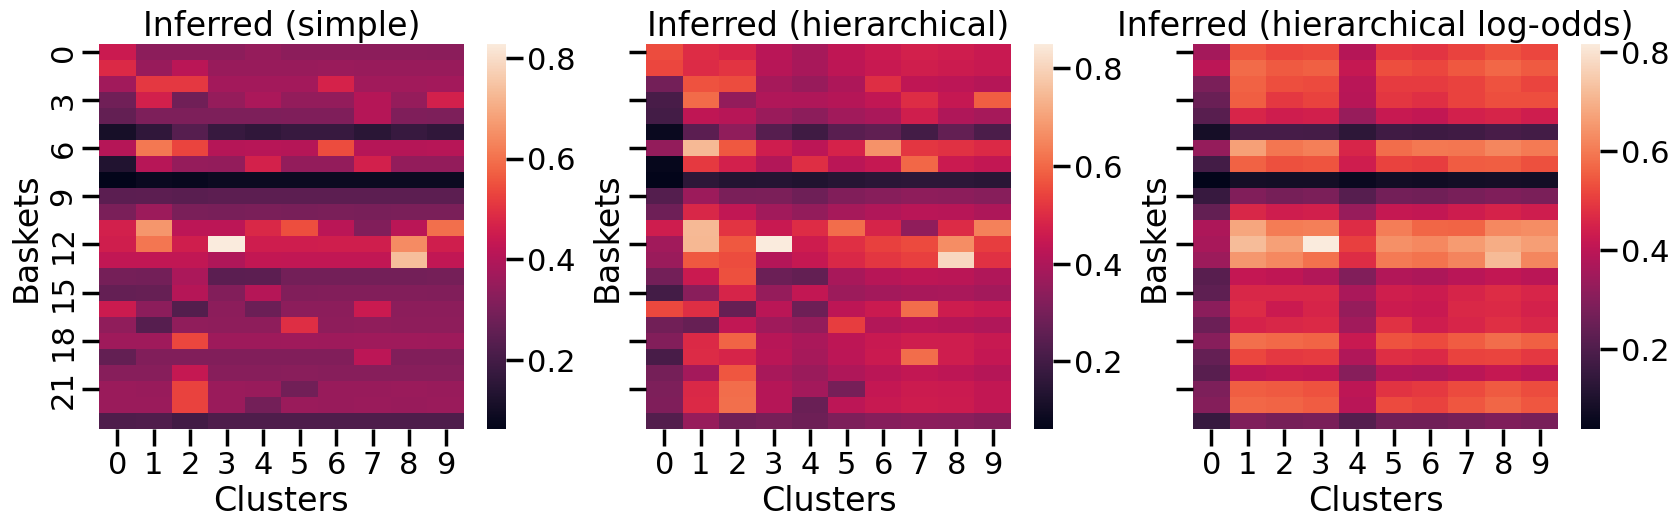

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
    
sns.heatmap(inferred_mat_s, ax=ax[0])
ax[0].set_title('Inferred (simple)')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h1, ax=ax[1])
ax[1].set_title('Inferred (hierarchical)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h2, ax=ax[2])
ax[2].set_title('Inferred (hierarchical log-odds)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')

## Model comparison

In [88]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [89]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 298 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -195.34     6.98
p_loo       30.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      290   97.3%
 (0.5, 0.7]   (ok)          8    2.7%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [90]:
loo_h1 = az.loo(trace_h1)
loo_h1

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 298 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -197.53     7.26
p_loo       39.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      260   87.2%
 (0.5, 0.7]   (ok)         33   11.1%
   (0.7, 1]   (bad)         5    1.7%
   (1, Inf)   (very bad)    0    0.0%

In [91]:
loo_h2 = az.loo(trace_h2)
loo_h2

Computed from 20000 posterior samples and 298 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -195.48     6.81
p_loo       27.55        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      296   99.3%
 (0.5, 0.7]   (ok)          2    0.7%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [92]:
ic = 'loo'
df_comp_loo = az.compare({
    's': loo_s, 
    'h1': loo_h1,
    'h2': loo_h2,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
s,0,-195.342724,30.804661,0.000000,5.174794e-01,6.979928,0.000000,False,log
h2,1,-195.480533,27.549619,0.137809,4.825206e-01,6.805784,2.669057,False,log
h1,2,-197.525653,39.438675,2.182929,4.440892e-16,7.263551,2.324270,True,log


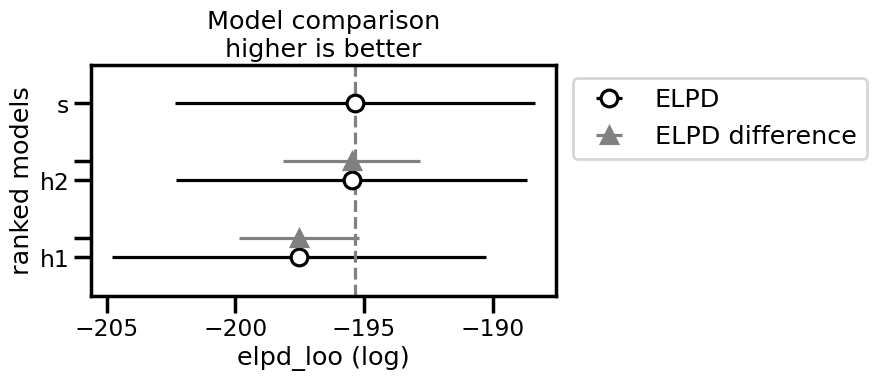

In [93]:
az.plot_compare(df_comp_loo);

# Save results

Save all the results to check in another notebook.

In [94]:
expr_df_filtered.shape, expr_df_selected.shape, len(class_labels), len(cluster_labels), patient_df.shape

((298, 19957), (298, 500), 298, 298, (298, 5))

In [95]:
drug_name, C

('Erlotinib', 10)

In [96]:
save_data = {
    'expr_df_filtered': expr_df_filtered,
    'expr_df_selected': expr_df_selected,
    'drug_response': drug_response,
    'class_labels': class_labels,
    'cluster_labels': cluster_labels,
    'patient_df': patient_df,
    'stacked_posterior': stacked_h2,
    'trace': trace_h2,
    'importance_df': importance_df
}
save_obj(save_data, os.path.join('results', 'patient_analysis_%s_cluster_%d.p' % (drug_name, C)))

2023-03-10 09:44:57.945 | INFO     | pyBasket.common:save_obj:62 - Saving <class 'dict'> to results/patient_analysis_Erlotinib_cluster_10.p


In [97]:
patient_df.to_csv(os.path.join('results', 'patient_analysis_%s_cluster_%d.csv' % (drug_name, C)))